In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:907: UserWarning: Duplicate key in file "/etc/matplotlibrc", line #469
  (fname, cnt))


# $U(x_1, x_2, x_3) = \frac{q^2 V^2}{m \Omega_{RF}^2 r_0^4}(x_1^2 + x_2^2 + 4 x_3^2)$

In [88]:
q = 1.6e-19
V = 200
m = 2.89e-25
omegaRF = 2*np.pi*40e6
rnot = 512e-6
A = q**2 * V**2/(m * omegaRF**2 * rnot**4)
wsec = np.sqrt(2*A/m)
print 'Secular freq = ', wsec/2/np.pi

Secular freq =  378274.863649


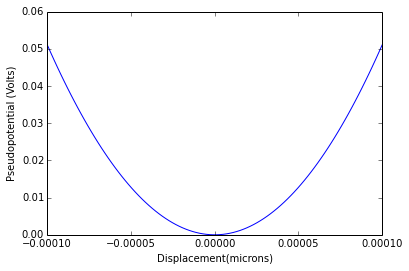

In [89]:
x = np.linspace(-100e-6,100e-6,100)
y = np.linspace(100e-6,-100e-6,100)
xx, yy = np.meshgrid(x,y)
phi = A*(xx**2 + 1 * yy**2)
plt.plot(x, A/q*x**2)
#plt.plot(y, A/q*x**2)
plt.ylabel('Pseudopotential (Volts)')
plt.xlabel('Displacement(microns)')
plt.show()


In [120]:
epsilon = 8.85e-12

def ion_distance(ion1, ion2):
    d = np.sqrt((ion1.x - ion2.x)**2 + (ion1.y - ion2.y)**2)
    return d

def interaction_energy(particle, otherions):
    Eint = 0
    for otherion in otherions:
        x_sep = otherion.x - particle.x
        y_sep = otherion.y - particle.y
        d = np.sqrt(x_sep**2 + y_sep**2)
        Eint += q**2/(4 * np.pi * epsilon * d)
    return 0.5 * Eint

def pos_energy(particle, assy = 1):
    pos_E = A * (assy * particle.x**2 + particle.y**2/assy ) 
    return pos_E

def total_energy(ions, assy):
    E_tot = 0
    for i, particle in enumerate(ions):
        otherions = ions[:i] + ions[i+1 :]
        E_tot += interaction_energy(particle, otherions)
        E_tot += pos_energy(particle, assy)
    return E_tot
    

def plot_ions(ions, colors = None, initial = False):
    x = []
    y = []
    if initial:
        for i, particle in enumerate(ions):
            x.append(particle.x0 * 1e6)
            y.append(particle.y0 * 1e6)        
    else:
        for i, particle in enumerate(ions):
            x.append(particle.x * 1e6)
            y.append(particle.y * 1e6)
    plt.axis('equal')
    #plt.axis([-25e-6, 25e-6, -25e-6, 25e-6])
    if colors:
        plt.scatter(x,y, c = colors) # in microns
    else: 
        plt.scatter(x,y)
    
class ion():
    def __init__(self, x0 = 0, y0= 0, ax0=0,ay0=0, constant = False):
        self.x0= x0
        self.x = self.x0
        self.y0 = y0
        self.y = self.y0
        self.constant = constant

# $$\ddot{\vec{x}}_{ij} = \frac{-2qA}{m}x_{ij} - \frac{q^2}{4 \pi \epsilon_0}\sum_{k\neq j}^{N} \frac{\hat{x}_{ij}\cdot \hat{r}}{|\vec{x}_k-\vec{x}_j|^2}$$

In [123]:
def make_crystal(N_ions = 6, pos_spread = 160e-6, iterations = 800, 
                 step_size = 1e-6, starting_ions = None, assy = 1):
    '''
    This function iterates random steps in postion and recalculates the energy of the configuration of N ions,
    if the energy is decreased it accepts the move and repeats
    '''

    N = N_ions
    ions = []
    if starting_ions == None:
        for i in range(N):
            x0 = (np.random.rand() - 0.5)*pos_spread # initiate ions in random position
            y0 = (np.random.rand() - 0.5)*pos_spread
            ions.append(ion(x0,y0))
    else:
        for i, starting_ion in enumerate(starting_ions): # initiate ions in specified starting positions
            ions.append(ion(starting_ion.x,starting_ion.y))
    E0 = total_energy(ions, assy)
    
    iters = 0
    E = [E0]
    last_E = E0

    while iters < iterations:
        iters +=1
        for i, particle in enumerate(ions):
            if particle.constant == False: # Checks if ion is movable
                particle.lastx = particle.x
                particle.x = particle.x + (np.random.rand() - 0.5)*step_size
                particle.lasty = particle.y
                particle.y = particle.y + (np.random.rand() - 0.5)*step_size
                tot_E = total_energy(ions, assy)
                if tot_E < last_E: # Check to take the position step or not
                    E.append(tot_E)
                    last_E = tot_E
                else:
                    particle.x = particle.lastx
                    particle.y = particle.lasty
                    
    return E[-1], ions


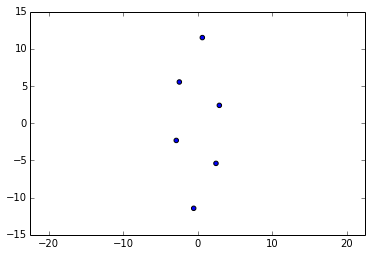

In [189]:
E, ions = make_crystal(N_ions = 6, assy = 2, iterations = 1000)
plot_ions(ions)

6.64e-06
5.97198336386e-22


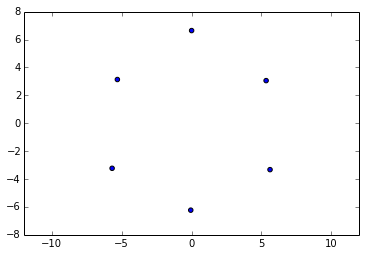

6.5736e-06
6.5072e-06
6.4408e-06
6.3744e-06
6.308e-06
6.2416e-06
6.1752e-06
6.1088e-06
6.0424e-06
5.976e-06
5.97193137098e-22


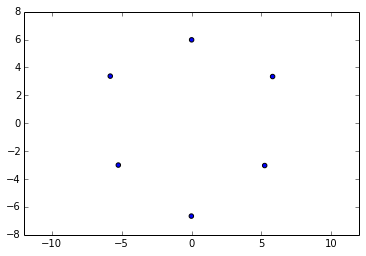

5.9096e-06
5.8432e-06
5.7768e-06
5.7104e-06
5.644e-06
5.5776e-06
5.5112e-06
5.4448e-06
5.3784e-06
5.312e-06
5.97307727703e-22


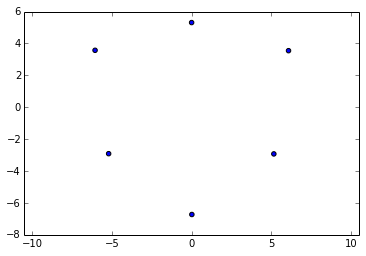

5.2456e-06
5.1792e-06
5.1128e-06
5.0464e-06
4.98e-06
4.9136e-06
4.8472e-06
4.7808e-06
4.7144e-06
4.648e-06
5.97522677548e-22


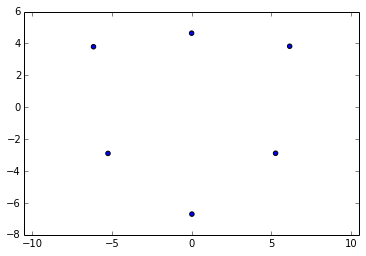

4.5816e-06
4.5152e-06
4.4488e-06
4.3824e-06
4.316e-06
4.2496e-06
4.1832e-06
4.1168e-06
4.0504e-06
3.984e-06
5.97640606437e-22


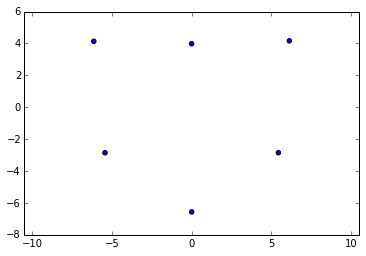

3.9176e-06
3.8512e-06
3.7848e-06
3.7184e-06
3.652e-06
3.5856e-06
3.5192e-06
3.4528e-06
3.3864e-06
3.32e-06
5.97399239789e-22


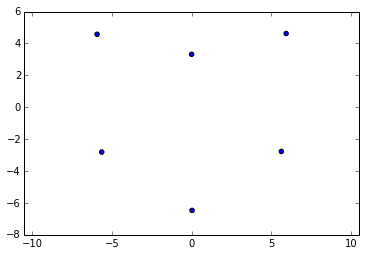

3.2536e-06
3.1872e-06
3.1208e-06
3.0544e-06
2.988e-06
2.9216e-06
2.8552e-06
2.7888e-06
2.7224e-06
2.656e-06
5.96631039822e-22


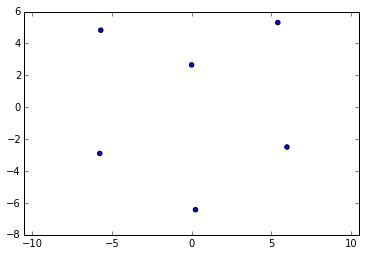

2.5896e-06
2.5232e-06
2.4568e-06
2.3904e-06
2.324e-06
2.2576e-06
2.1912e-06
2.1248e-06
2.0584e-06
1.992e-06
5.95402483408e-22


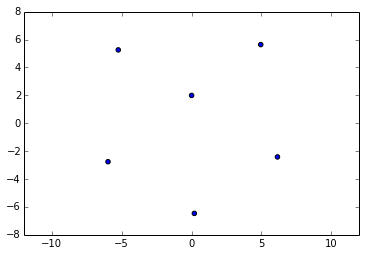

1.9256e-06
1.8592e-06
1.7928e-06
1.7264e-06
1.66e-06
1.5936e-06
1.5272e-06
1.4608e-06
1.3944e-06
1.328e-06
5.94139563897e-22


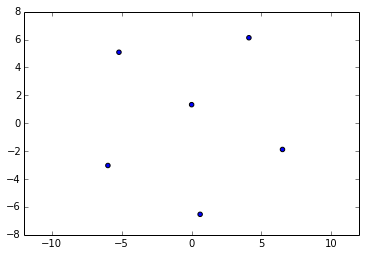

1.2616e-06
1.1952e-06
1.1288e-06
1.0624e-06
9.96e-07
9.296e-07
8.632e-07
7.968e-07
7.304e-07
6.64e-07
5.93236478216e-22


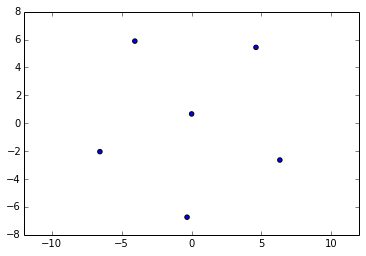

5.976e-07
5.312e-07
4.648e-07
3.984e-07
3.32e-07
2.656e-07
1.992e-07
1.328e-07
6.64e-08


In [82]:
Eprofile = []
Ydistance = []
for i in range(100):
    starting_ions = symmetric_6(6.64e-6)
    starting_ions[0].y = starting_ions[0].y - starting_ions[0].y * 0.01 * i
    print starting_ions[0].y
    Ydistance.append(starting_ions[0].y)
    ions[0].constant = True
    E, ions = make_crystal(6, starting_ions = starting_ions, iterations = 2000, pos_spread = 20e-6)
    Eprofile.append(E)
    if i % 10 == 0:
        print E
        plt.show()
        plot_ions(ions)
        plt.savefig('simulated_%s_ion_.pdf' % str(len(ions)))
        plt.show() 

In [21]:
for particle in ions:
    print particle.x

-2.87685327176e-06
-6.72685286004e-06
3.22463895913e-06
-3.12705444104e-06
3.49729993079e-06
6.00549318529e-06


In [22]:
meta_6_ions = ions

In [72]:
print Eprofile[-1]

5.92922348689e-22


In [31]:
def symmetric_6(radius):
    ions = []
    ions.append(ion(0,radius))
    ions.append(ion(0,-radius))
    x = radius * np.cos(np.pi/6)
    y = radius * np.sin(np.pi/6)freq = (Eprofile - np.min(Eprofile))/6.6e-34
    ions.append(ion(x,y))
    ions.append(ion(-x,-y))
    ions.append(ion(-x,y))
    ions.append(ion(x,-y))
    return ions

In [27]:
print np.sqrt(ions[0].x**2  + ions[0].y**2)

6.64039147359e-06


In [83]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)

In [62]:
print np.min(Eprofile)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
print freq

5.92998764894e-22
[  6.35645416e+09   6.66570421e+09   4.29811012e+09   2.64665671e+09
   1.72757523e+09   1.18576774e+09   8.50226815e+08   6.25886950e+08
   4.71589244e+08   3.60217580e+08   2.77527006e+08   2.14107359e+08
   1.65392142e+08   1.25056058e+08   9.45092040e+07   6.78234726e+07
   4.61400013e+07   2.75948246e+07   1.27215071e+07   0.00000000e+00]


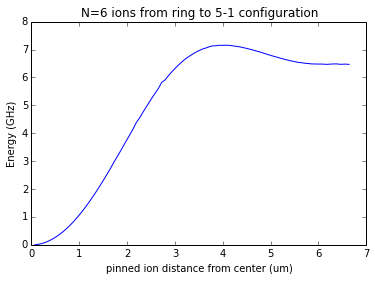

In [71]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance * 1e6, freq/1e9)
plt.title('N=6 ions from ring to 5-1 configuration')
plt.xlabel('pinned ion distance from center (um)')
plt.ylabel('Energy (GHz)')
plt.savefig('6ring-5_1_transition.pdf')

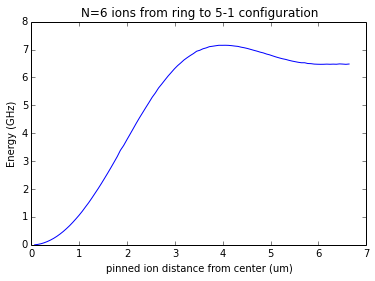

In [84]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)10
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance * 1e6, freq/1e9)
plt.title('N=6 ions from ring to 5-1 configuration')
plt.xlabel('pinned ion distance from center (um)')
plt.ylabel('Energy (GHz)')
plt.savefig('6ring-5_1_transition.pdf')

In [ ]:
Eprofile = np.array(Eprofile)
Ydistance = np.array(Ydistance)
freq = (Eprofile - np.min(Eprofile))/6.6e-34
plt.plot(Ydistance * 1e6, freq/1e9)
plt.title('N=6 ions from ring to 5-1 configuration')
plt.xlabel('pinned ion distance from center (um)')
plt.ylabel('Energy (GHz)')
plt.savefig('6ring-5_1_transition.pdf')